# K_MEANS CLUSTERING

In this notebook, we are going to take customers raw data in form of excel csv, Import those raw data into SQL data base, then create a connection between sql and python and import the data. We will preprocessed the data using python and run PCA in oder to reduce data dimensionality. and then run KMeans Clustering. We will send our data with the results of our Kmeans into SQL. Then create a connection between SQL and PowerBi to deploy the unserpervized machine learning results into PowerBi dashboard to visualized the data and get more insights.

**1.Problem defition**
> How well can we predict to which cluster belongs each customers?

In [140]:
import os
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pyodbc

from sklearn.cluster import KMeans, k_means
%matplotlib inline

pd.options.display.max_columns = None
pd.options.display.max_rows = None
import warnings
warnings.filterwarnings("ignore")
#Cufflinks libraries
import cufflinks as cf
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
cf.go_offline()

# To change scientific numbers to float
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
# Increases the size of sns plots
#sns.set(rc={'figure.figsize':(8,4)})

# 1.LOAD DATA

In [174]:
#To open a connextion with sql server
connStr = pyodbc.connect('DRIVER={SQL Server Native Client 11.0};\
                            SERVER=DESKTOP-JDQLDT1\MSSQLSERVER01;\
                            DATABASE=Customer_Raw_Data;\
                            Trusted_Connection=yes')

In [175]:
%%time
cursor = connStr.cursor()
sqlquery_back_up = pd.read_sql_query("SELECT * FROM Events_Raw_Data", connStr)

raw_data = sqlquery_back_up.copy()
df_shape = (raw_data.shape)
print(f"There are {df_shape[0]} rows and {df_shape[1]} columns in the dataset")
print(f"Data timeperiod covers: {min(raw_data.index)} to {max(raw_data.index)}")
raw_data.head()

There are 14783 rows and 19 columns in the dataset
Data timeperiod covers: 0 to 14782
Wall time: 318 ms


,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I don't spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree


In [176]:
#To close connexion
connStr.close()

# 2.DATA PREPROCESSING

**1.EDA**

In [177]:
# Checking for null values
raw_data.isnull().sum()

CUSTOMER                                                       0
Age                                                            0
Gender                                                         0
Postcode                                                       0
District                                                       0
Constituency                                                   0
latitude                                                       0
longitude                                                      0
Current_Status                                                 0
Total_Household_Income                                         5
How_often_you_attend_Entertaining_events_in_a_year             5
Social_Media                                                   5
How_many_hours_are_you_willing_to_travel_to_attend_an_event    5
Do_you_enjoy_adrenaline_rush_activities                        5
Are_food_areas_coffee_areas_bars_toilets_important_to_you      5
What_is_your_favourite_at

In [178]:
raw_data[raw_data['Total_Household_Income'].isnull()]

,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money
21,23,50-60,Female,EN3 4YQ,Enfield,Edmonton,51.643546,-0.029532,Married with children,None,None,None,None,None,None,None,None,None,None
22,24,50-61,Female,EN3 4YQ,Enfield,Edmonton,51.643546,-0.029532,Married with children,None,None,None,None,None,None,None,None,None,None
23,25,50-62,Female,EN3 4YQ,Enfield,Edmonton,51.643546,-0.029532,Married with children,None,None,None,None,None,None,None,None,None,None
24,26,50-63,Female,EN3 4YQ,Enfield,Edmonton,51.643546,-0.029532,Married with children,None,None,None,None,None,None,None,None,None,None
25,27,50-64,Female,EN3 4YQ,Enfield,Edmonton,51.643546,-0.029532,Married with children,None,None,None,None,None,None,None,None,None,None


In [179]:
print(raw_data.shape)

(14783, 19)


In [180]:
# Deleting the NULL values
raw_data = raw_data.dropna(subset = ['Total_Household_Income'])
# Printing the shape
print(raw_data.shape)
# Visualize the NULL observations
raw_data.isnull().sum()

(14778, 19)


CUSTOMER                                                       0
Age                                                            0
Gender                                                         0
Postcode                                                       0
District                                                       0
Constituency                                                   0
latitude                                                       0
longitude                                                      0
Current_Status                                                 0
Total_Household_Income                                         0
How_often_you_attend_Entertaining_events_in_a_year             0
Social_Media                                                   0
How_many_hours_are_you_willing_to_travel_to_attend_an_event    0
Do_you_enjoy_adrenaline_rush_activities                        0
Are_food_areas_coffee_areas_bars_toilets_important_to_you      0
What_is_your_favourite_at

In [181]:
#To make a copy of the original DataFrame
raw_data_temp = raw_data.copy()

In [182]:
raw_data_temp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14778 entries, 0 to 14782
Data columns (total 19 columns):
 #   Column                                                       Non-Null Count  Dtype  
---  ------                                                       --------------  -----  
 0   CUSTOMER                                                     14778 non-null  int64  
 1   Age                                                          14778 non-null  object 
 2   Gender                                                       14778 non-null  object 
 3   Postcode                                                     14778 non-null  object 
 4   District                                                     14778 non-null  object 
 5   Constituency                                                 14778 non-null  object 
 6   latitude                                                     14778 non-null  float64
 7   longitude                                                    14778 non-null 

In [8]:
#Find the column that contains string
for label, content in raw_data_temp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

Age
Gender
Postcode
District
Constituency
Current_Status
Total_Household_Income
How_often_you_attend_Entertaining_events_in_a_year
Social_Media
How_many_hours_are_you_willing_to_travel_to_attend_an_event
Do_you_enjoy_adrenaline_rush_activities
Are_food_areas_coffee_areas_bars_toilets_important_to_you
What_is_your_favourite_attraction_from_below
Were_you_satisfied_with_the_last_event_you_attended_with_us
Would_you_recommend_our_events_to_other_people
Did_you_find_our_events_value_for_money


In [171]:
# Investigate all the elements whithin each Feature 
for column in raw_data_temp:
    unique_vals = np.unique(raw_data_temp[column])
    nr_values = len(unique_vals)
    if nr_values < 10:
        print('The number of values for feature {} :{} -- {}'.format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'.format(column, nr_values))

The number of values for feature CUSTOMER :14778
The number of values for feature Age :9 -- ['17 or younger' '18-20' '21-25' '26-32' '33-39' '40-49' '50-59' '60-64'
 '65 or older']
The number of values for feature Gender :2 -- ['Female' 'Male']
The number of values for feature Postcode :14674
The number of values for feature District :225
The number of values for feature Constituency :358
The number of values for feature latitude :13242
The number of values for feature longitude :13262
The number of values for feature Current_Status :8 -- ['Divorced' 'Living with partner' 'Married with children'
 'Married without children' 'Separated' 'Single, never married'
 'Step parent' 'Widowed']
The number of values for feature Total_Household_Income :8 -- ['100,000 to 149,999' '150,000 to 199,999' '20,000 to 34,999'
 '200,000 or more' '35,000 to 49,999' '50,000 to 74,999'
 '75,000 to 99,999' 'Less than 20,000']
The number of values for feature How_often_you_attend_Entertaining_events_in_a_year :5

In [155]:
print(raw_data_temp["Total_Household_Income"].value_counts())
print(raw_data_temp["Total_Household_Income"].unique())

50,000 to 74,999      3603
35,000 to 49,999      2631
75,000 to 99,999      2347
20,000 to 34,999      2110
100,000 to 149,999    1902
Less than 20,000       770
200,000 or more        718
150,000 to 199,999     697
Name: Total_Household_Income, dtype: int64
['50,000 to 74,999' '35,000 to 49,999' '75,000 to 99,999'
 '100,000 to 149,999' '150,000 to 199,999' '200,000 or more' None
 '20,000 to 34,999' 'Less than 20,000']


In [183]:
# Getting the columns we need
raw_data_temp.columns

Index(['CUSTOMER', 'Age', 'Gender', 'Postcode', 'District', 'Constituency',
       'latitude', 'longitude', 'Current_Status', 'Total_Household_Income',
       'How_often_you_attend_Entertaining_events_in_a_year', 'Social_Media',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event',
       'Do_you_enjoy_adrenaline_rush_activities',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you',
       'What_is_your_favourite_attraction_from_below',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us',
       'Would_you_recommend_our_events_to_other_people',
       'Did_you_find_our_events_value_for_money'],
      dtype='object')

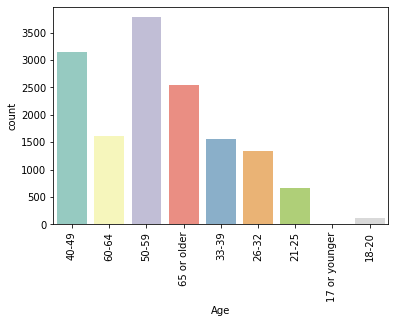

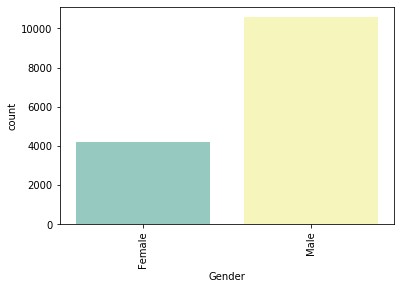

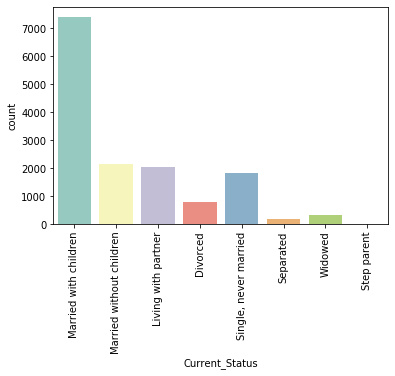

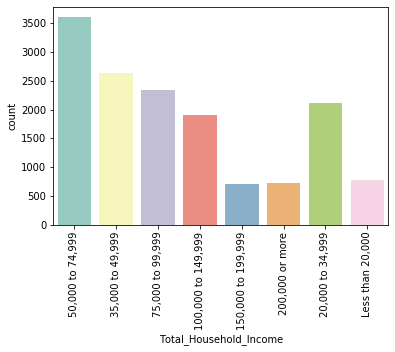

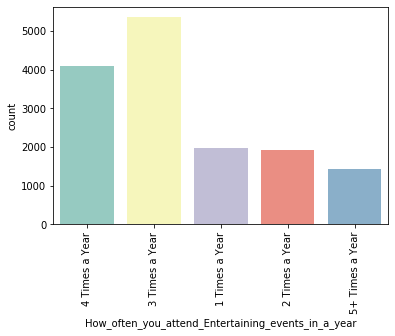

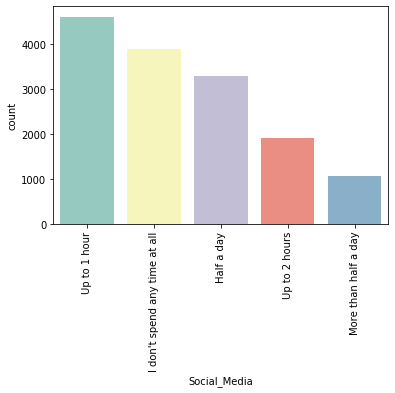

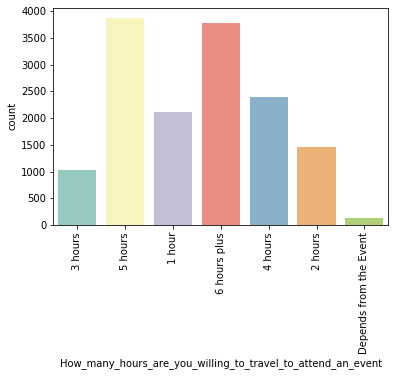

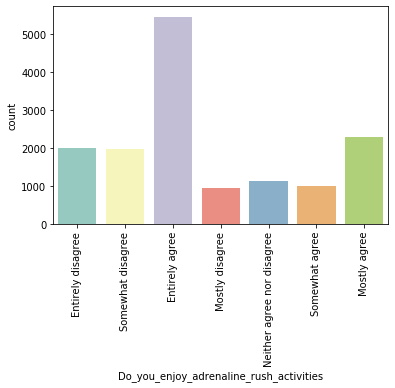

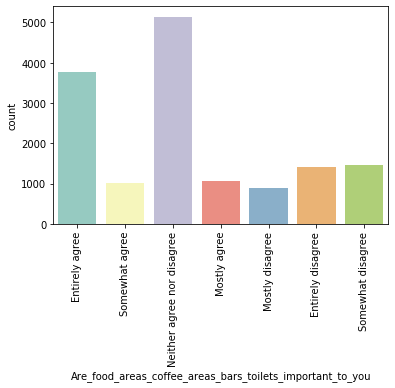

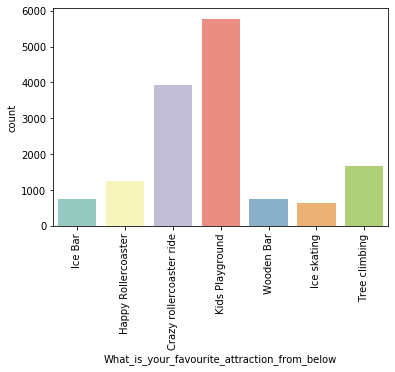

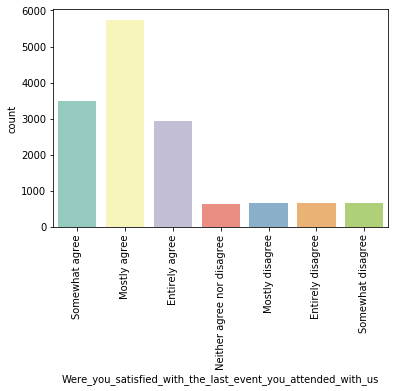

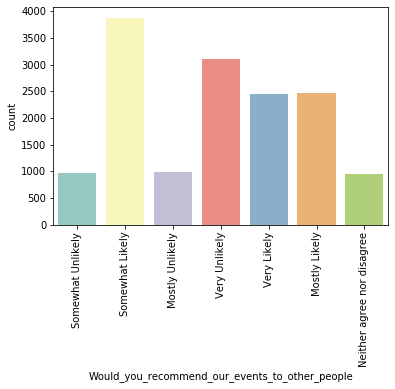

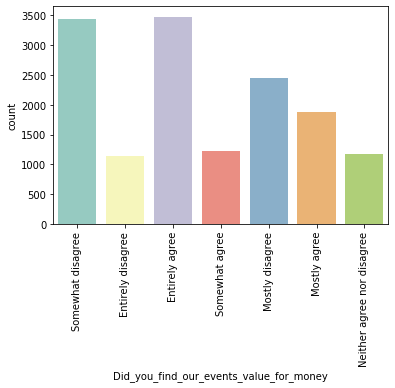

In [184]:
# Looping through all the features by our y variable - see if there is relationship
# We remove all variables with high number of unique values
#"The number of values for feature CUSTOMER" 
#"The number of values for feature Postcode :14674
#The number of values for feature District :225
#The number of values for feature Constituency :358
#The number of values for feature latitude :13242
#The number of values for feature longitude :13262"
features = ['Age', 'Gender', 'Current_Status', 'Total_Household_Income',
       'How_often_you_attend_Entertaining_events_in_a_year', 'Social_Media',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event',
       'Do_you_enjoy_adrenaline_rush_activities',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you',
       'What_is_your_favourite_attraction_from_below',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us',
       'Would_you_recommend_our_events_to_other_people',
       'Did_you_find_our_events_value_for_money']

for f in features:
    sns.countplot(x = f, data = raw_data_temp, palette = 'Set3')# hue = '')
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
#From the EDA we have a very large group of people attending entertaining events 4 and 3 times a year and few group attending 1, 2 and more than 5 times.
#We can combine 1 and 2 together since they don't have enogh samples. Similarly, we can combine 4 and 5+times together.

**2.FEATURES INGINEERING**

In [185]:
# Creating a distance function - took this ready from the web 
def haversine_vectorize(lon1, lat1, lon2, lat2):
 
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
 
    newlon = lon2 - lon1
    newlat = lat2 - lat1
 
    haver_formula = np.sin(newlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(newlon/2.0)**2
 
    dist = 2 * np.arcsin(np.sqrt(haver_formula ))
    km = 6367 * dist #6367 for distance in KM for miles use 3958
    return km

In [186]:
# Creating lat and long for our event - randoms
raw_data_temp['Event_Lat'] = '51.5073'
raw_data_temp['Event_Lon'] = '0.1657'


haversine_vectorize(raw_data_temp['Event_Lon'].astype(float) ,raw_data_temp['Event_Lat'].astype(float), raw_data_temp['longitude'].astype(float) ,
                   raw_data_temp['latitude'].astype(float))


raw_data_temp['DistanceFromEvent'] = haversine_vectorize(raw_data_temp['Event_Lon'].astype(float) ,raw_data_temp['Event_Lat'].astype(float), raw_data_temp['longitude'].astype(float) ,
                   raw_data_temp['latitude'].astype(float))

In [187]:
raw_data_temp.head()

,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money,Event_Lat,Event_Lon,DistanceFromEvent
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree,51.5073,0.1657,34.342502
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree,51.5073,0.1657,41.376761
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I don't spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree,51.5073,0.1657,701.484783
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree,51.5073,0.1657,176.943287
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree,51.5073,0.1657,17.216110


In [16]:
#To convert all the string values into category values
for label, content in raw_data_temp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

CUSTOMER
latitude
longitude
DistanceFromEvent


In [17]:
#equals all columns excluded location columns
features

['Age',
 'Gender',
 'Current_Status',
 'Total_Household_Income',
 'How_often_you_attend_Entertaining_events_in_a_year',
 'Social_Media',
 'How_many_hours_are_you_willing_to_travel_to_attend_an_event',
 'Do_you_enjoy_adrenaline_rush_activities',
 'Are_food_areas_coffee_areas_bars_toilets_important_to_you',
 'What_is_your_favourite_attraction_from_below',
 'Were_you_satisfied_with_the_last_event_you_attended_with_us',
 'Would_you_recommend_our_events_to_other_people',
 'Did_you_find_our_events_value_for_money']

In [188]:
# Making categorical variables into numeric representation
print(raw_data_temp.shape)
# keeping the columns we need - Drop the location columns for now, as we do not want them to impact our results (for now)
raw_data_without_loc = raw_data_temp[features]
print(raw_data_without_loc.shape)
# Making categorical variables into numeric representation
new_raw_data = pd.get_dummies(raw_data_without_loc, columns = features)
# Notes:
# We can also do this with Label Encoding and OneHotEncoder from the preprocessing library
print(new_raw_data.shape)

(14778, 22)
(14778, 13)
(14778, 86)


In [189]:
# print the shape
new_raw_data.head()

,Age_17 or younger,Age_18-20,Age_21-25,Age_26-32,Age_33-39,Age_40-49,Age_50-59,Age_60-64,Age_65 or older,Gender_Female,Gender_Male,Current_Status_Divorced,Current_Status_Living with partner,Current_Status_Married with children,Current_Status_Married without children,Current_Status_Separated,"Current_Status_Single, never married",Current_Status_Step parent,Current_Status_Widowed,"Total_Household_Income_100,000 to 149,999","Total_Household_Income_150,000 to 199,999","Total_Household_Income_20,000 to 34,999","Total_Household_Income_200,000 or more","Total_Household_Income_35,000 to 49,999","Total_Household_Income_50,000 to 74,999","Total_Household_Income_75,000 to 99,999","Total_Household_Income_Less than 20,000",How_often_you_attend_Entertaining_events_in_a_year_1 Times a Year,How_often_you_attend_Entertaining_events_in_a_year_2 Times a Year,How_often_you_attend_Entertaining_events_in_a_year_3 Times a Year,How_often_you_attend_Entertaining_events_in_a_year_4 Times a Year,How_often_you_attend_Entertaining_events_in_a_year_5+ Times a Year,Social_Media_Half a day,Social_Media_I don't spend any time at all,Social_Media_More than half a day,Social_Media_Up to 1 hour,Social_Media_Up to 2 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_1 hour,How_many_hours_are_you_willing_to_travel_to_attend_an_event_2 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_3 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_4 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_5 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_6 hours plus,How_many_hours_are_you_willing_to_travel_to_attend_an_event_Depends from the Event,Do_you_enjoy_adrenaline_rush_activities_Entirely agree,Do_you_enjoy_adrenaline_rush_activities_Entirely disagree,Do_you_enjoy_adrenaline_rush_activities_Mostly agree,Do_you_enjoy_adrenaline_rush_activities_Mostly disagree,Do_you_enjoy_adrenaline_rush_activities_Neither agree nor disagree,Do_you_enjoy_adrenaline_rush_activities_Somewhat agree,Do_you_enjoy_adrenaline_rush_activities_Somewhat disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely agree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly agree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Neither agree nor disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat agree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat disagree,What_is_your_favourite_attraction_from_below_Crazy rollercoaster ride,What_is_your_favourite_attraction_from_below_Happy Rollercoaster,What_is_your_favourite_attraction_from_below_Ice Bar,What_is_your_favourite_attraction_from_below_Ice skating,What_is_your_favourite_attraction_from_below_Kids Playground,What_is_your_favourite_attraction_from_below_Tree climbing,What_is_your_favourite_attraction_from_below_Wooden Bar,Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely agree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely disagree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly agree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly disagree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Neither agree nor disagree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat agree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat disagree,Would_you_recommend_our_events_to_other_people_Mostly Likely,Would_you_recommend_our_events_to_other_people_Mostly Unlikely,Would_you_recommend_our_events_to_other_people_Neither agree nor disagree,Would_you_recommend_our_events_to_other_people_Somewhat Likely,Would_you_recommend_our_events_to_other_people_Somewhat Unlikely,Would_you_recommend_our_events_to_other_people_Very Likely,Would_you_recommend_ou

# 3.MODELLING

In [190]:
%%time
X_train = new_raw_data.values
# We wills start with 5 clusters
#instantiates the model 
kmeans = KMeans(n_clusters=5, random_state=88)
#Fit the model with the data
kmeans = kmeans.fit(X_train)
# Prints the clusters it assigned to each observation
print("The clusters are: ", kmeans.labels_)
# Prints the Inertia
print("The Inertia is: ", kmeans.inertia_)

The clusters are:  [4 4 4 ... 4 1 4]
The Inertia is:  100865.17297153916
Wall time: 1.88 s


In [21]:
%%time
# Running K means with multible Ks
nber_of_clusters = np.arange(1, 20, 1)
inertia = []
for K in nber_of_clusters:
    kmeans = KMeans(n_clusters=K, random_state=2)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", K, "Clusters is:", u)

The innertia for : 1 Clusters is: 144679.35466414125
The innertia for : 2 Clusters is: 125644.06339664149
The innertia for : 3 Clusters is: 115200.5185274353
The innertia for : 4 Clusters is: 106361.52163527001
The innertia for : 5 Clusters is: 101925.20028044684
The innertia for : 6 Clusters is: 96457.47571097229
The innertia for : 7 Clusters is: 94222.85680501418
The innertia for : 8 Clusters is: 91723.3835052462
The innertia for : 9 Clusters is: 90087.20456420117
The innertia for : 10 Clusters is: 88486.8559888648
The innertia for : 11 Clusters is: 87612.88693005807
The innertia for : 12 Clusters is: 86831.83853116013
The innertia for : 13 Clusters is: 86108.61475306707
The innertia for : 14 Clusters is: 85158.32493848758
The innertia for : 15 Clusters is: 84538.54426988814
The innertia for : 16 Clusters is: 83718.47036008154
The innertia for : 17 Clusters is: 83234.84486341296
The innertia for : 18 Clusters is: 82447.57645918113
The innertia for : 19 Clusters is: 81932.85987190236


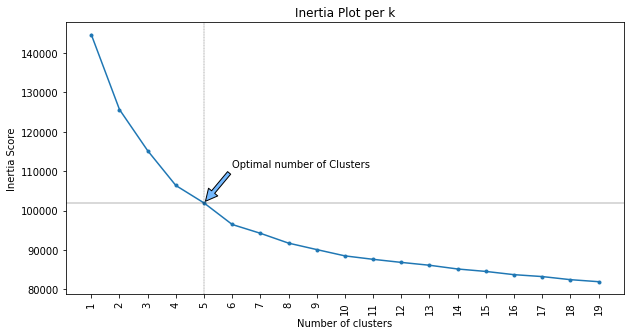

In [55]:
# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(10,5))
xx = np.arange(len(nber_of_clusters))
ax1.plot(xx, inertia, marker='o', markersize = 3)
ax1.set_xticks(xx)

plt.axhline(101925, color="k", linestyle="-", linewidth=.30)
plt.axvline(4,color="k", linestyle="--", linewidth=.30)

plt.annotate('Optimal number of Clusters', xy=(4, 101925), 
             xytext=(5, 111000),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))

ax1.set_xticklabels(nber_of_clusters, rotation='vertical')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k");

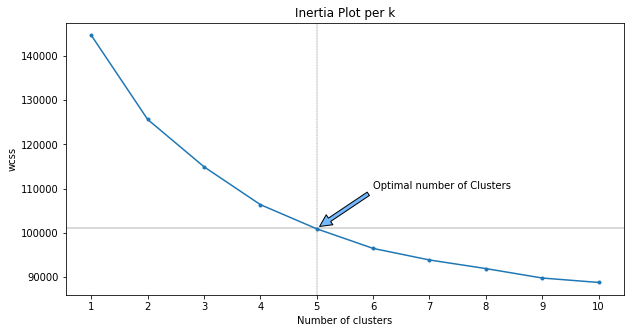

Wall time: 17.4 s


In [61]:
%%time
#wcss=Within Cluster Sum of Square 
wcss=[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init="k-means++", max_iter=300, random_state=88, n_init=10)
    kmeans = kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)
plt.rc('figure', figsize=(10, 5))

plt.axhline(101000, color="k", linestyle="-", linewidth=.30)
plt.axvline(5,color="k", linestyle="--", linewidth=.30)

plt.annotate('Optimal number of Clusters', xy=(5, 101000), 
             xytext=(6, 110000),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))

plt.plot(range(1, 11), wcss, marker='o', markersize = 3)
plt.title("Inertia Plot per k")
plt.xlabel('Number of clusters')
plt.ylabel('wcss')
plt.xticks(range(1, 11))
plt.show()

In [62]:
# Running K means on 5 clusters
kmeans = KMeans(n_clusters=5, init="k-means++", max_iter=300, random_state=88, n_init=10)
kmeans = kmeans.fit(X_train)
kmeans.labels_
# "predictions" for new data
y_kmeans = kmeans.predict(X_train)
# calculating the Counts of the cluster
unique, counts = np.unique(y_kmeans, return_counts=True)
counts = counts.reshape(1,5)
# Creating a datagrame to visualize how many customers we have per clusters
countscldf = pd.DataFrame(counts, columns = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"])
# display
countscldf

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,988,8496,2208,1226,1865


In [31]:
y_kmeans.T

array([1, 1, 1, ..., 1, 2, 1])

In [32]:
raw_data_temp["CUSTOMER"]

0            1
1            2
2            3
3            4
4            5
5            6
6            7
7            8
8            9
9           10
10          11
11          12
12          13
13          14
14          16
15          17
16          18
17          19
18          20
19          21
20          22
21          23
22          24
23          25
24          26
25          27
26          23
27          24
28          25
29          26
30          27
31          28
32          29
33          31
34          32
35          34
36          37
37          38
38          40
39          41
40          42
41          44
42          45
43          47
44          48
45          49
46          50
47          51
48          52
49          53
50          54
51       15925
52          55
53          56
54          57
55          58
56          59
57          61
58          62
59          63
60          64
61          65
62          66
63          67
64          68
65          69
66        

# 4.RUNNING PCA TO REDUCE DATA DIMENSIONALITY

In [63]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Explained variance ratio (first two components): [0.167329 0.078165]


<Figure size 720x360 with 0 Axes>

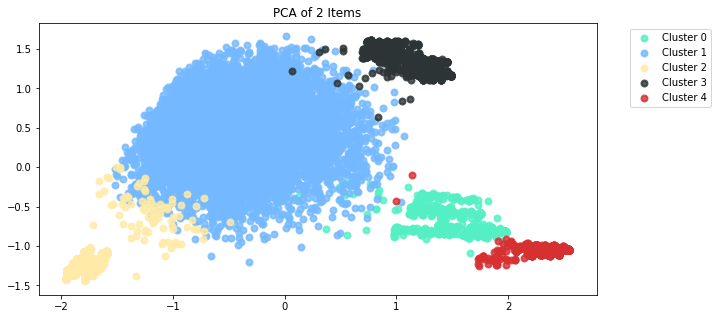

Wall time: 497 ms


In [72]:
%%time
X = X_train
y_num = y_kmeans

target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]
#instantiate pca model to 2 principal components
pca = PCA(n_components=2, random_state = 88)
#X_r dimension reduced
X_r = pca.fit(X).transform(X)
# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s'% str(pca.explained_variance_ratio_))
# Plotting the data
plt.figure()
plt.figure(figsize=(10,5))
colors = ['#55efc4', '#74b9ff', '#ffeaa7', '#2d3436', '#d63031']
lw = 2

for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show();

In [191]:
X = X_train
y_num = y_kmeans

.The first two components explain about 16.73% + 7.81% = 24% of the variance in our data set. 

**IDENTIFYING THE OPTIMAL NUMBER OF COMPONENTS**

In [73]:
# Trying with Dimentionality reduction and then Kmeans
n_components = X.shape[1]#all columns
# Running PCA with all components
pca = PCA(n_components=n_components, random_state = 88)
X_r = pca.fit(X).transform(X)
# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_95 = total_variance * 0.95
print("The 95% variance we want to have is: ", var_95)
print("")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
print("Variance explain with 30 n_compononets: ", sum(a["Explained Variance"][0:30]))
print("Variance explain with 35 n_compononets: ", sum(a["Explained Variance"][0:35]))
print("Variance explain with 40 n_compononets: ", sum(a["Explained Variance"][0:40]))
print("Variance explain with 41 n_compononets: ", sum(a["Explained Variance"][0:41]))
print("Variance explain with 50 n_compononets: ", sum(a["Explained Variance"][0:50]))
print("Variance explain with 53 n_compononets: ", sum(a["Explained Variance"][0:53]))
print("Variance explain with 55 n_compononets: ", sum(a["Explained Variance"][0:55]))
print("Variance explain with 60 n_compononets: ", sum(a["Explained Variance"][0:60]))

Total Variance in our dataset is:  9.78753583169673
The 95% variance we want to have is:  9.298159040111893

Variance explain with 30 n_compononets:  7.797887369638196
Variance explain with 35 n_compononets:  8.19779807163099
Variance explain with 40 n_compononets:  8.556984090736616
Variance explain with 41 n_compononets:  8.62280982195624
Variance explain with 50 n_compononets:  9.154678179565607
Variance explain with 53 n_compononets:  9.299221695428413
Variance explain with 55 n_compononets:  9.38892000620532
Variance explain with 60 n_compononets:  9.589635823807933


In [74]:
X.shape[1]

91

.The number of components that explain 95% variance of our data set is 53 n_components.

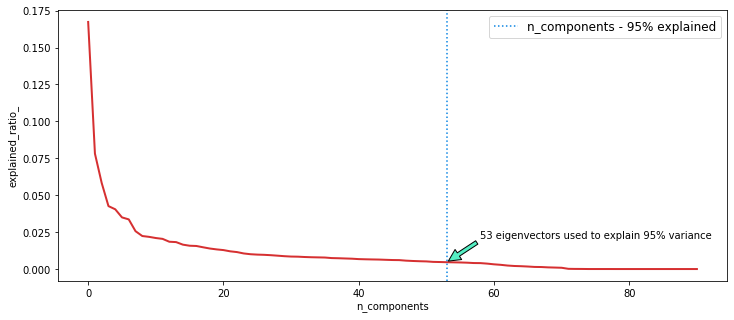

In [78]:
# Plotting the Data
plt.figure(1, figsize=(12, 5))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c="#d63031")
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')
# Plotting line with 95% e.v.
plt.axvline(53,linestyle=':', label='n_components - 95% explained', c ="#0984e3")
plt.legend(prop=dict(size=12))
# adding arrow
plt.annotate('53 eigenvectors used to explain 95% variance', xy=(53, pca.explained_variance_ratio_[53]), 
             xytext=(58, pca.explained_variance_ratio_[10]),
            arrowprops=dict(facecolor='#55efc4', shrink=0.05))
plt.show()
#eigenvectors equals principal components

**FITTING THE KMEANS MODEL USING X_TRAIN REDUCED** 

The innertia for : 1 Clusters is: 137460.4772497352
The innertia for : 2 Clusters is: 118428.63741306456
The innertia for : 3 Clusters is: 107716.47413331798
The innertia for : 4 Clusters is: 99160.80208422712
The innertia for : 5 Clusters is: 93698.19692613931
The innertia for : 6 Clusters is: 89270.29529714947
The innertia for : 7 Clusters is: 86652.64523727357
The innertia for : 8 Clusters is: 84541.62255182797
The innertia for : 9 Clusters is: 82581.41731110253
The innertia for : 10 Clusters is: 81329.05380055842
The innertia for : 11 Clusters is: 80352.51003389466
The innertia for : 12 Clusters is: 79481.80838216351
The innertia for : 13 Clusters is: 78716.59596866649
The innertia for : 14 Clusters is: 77848.91654351316
The innertia for : 15 Clusters is: 77100.82362254948
The innertia for : 16 Clusters is: 76391.65213860343
The innertia for : 17 Clusters is: 75826.00877314707
The innertia for : 18 Clusters is: 75243.53844997814
The innertia for : 19 Clusters is: 74682.46361241865


Text(0.5, 1.0, 'Inertia Plot per k')

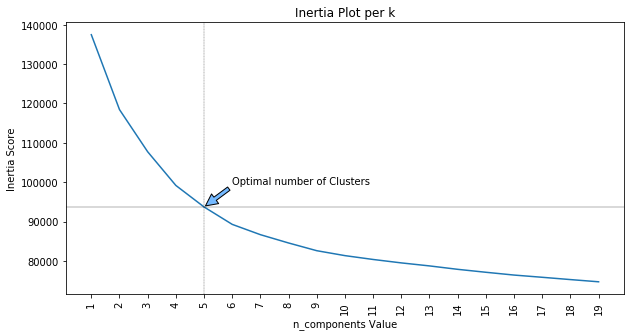

In [83]:
%%time
# Running PCA again
#X_r =X with 53 components(dimensionality reduced)
pca = PCA(n_components=53, random_state = 88)
X_r = pca.fit(X).transform(X)
inertia = []
#running Kmeans
for k in nber_of_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, random_state=88, n_init=10)
    kmeans = kmeans.fit(X_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", k, "Clusters is:", u)

# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(10,5))
xx = np.arange(len(nber_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(nber_of_clusters, rotation='vertical')

plt.axhline(93698, color="k", linestyle="-", linewidth=.30)
plt.axvline(4,color="k", linestyle="--", linewidth=.30)

plt.annotate('Optimal number of Clusters', xy=(4, 93698), 
             xytext=(5, 99500),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))

plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

.We Improved the results by reducing the dimensionnality

**Clean/Combine Variables IN ORDER TO IMPROVE OUR RESULTS**

In [111]:
new_raw_data_back_up = pd.get_dummies(raw_data_without_loc, columns = features)
new_raw_data = new_raw_data_back_up.copy()

In [112]:
#We create a new column (variable) that combine 1 and 2 times and set it to zero. If 1 Times a Year or 2 Times a Year equals 1, then our newly created variable
#will take the value 1. We keep repeating the same process for other variables.
print("The shape is: ", new_raw_data.shape)
# Cleaning the "'How_often_you_attend_Entertaining_events_in_a_year" column
# 1-2 times
new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_1_or_2_times'] = 0
new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_1_or_2_times']\
    [(new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_1 Times a Year'] == 1) |\
     (new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_2 Times a Year'] == 1)] = 1

# 4-5 times
new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_4_or_5_times'] = 0
new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_4_or_5_times']\
    [(new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_4 Times a Year'] == 1) |\
     (new_raw_data['How_often_you_attend_Entertaining_events_in_a_year_5+ Times a Year'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)


# Cleaning the "social_media" column

# half a day + more than half a day
new_raw_data['Social_Media_Half_a_day_plus'] = 0
new_raw_data['Social_Media_Half_a_day_plus']\
    [(new_raw_data['Social_Media_Half a day'] == 1) |\
     (new_raw_data['Social_Media_More than half a day'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)


# Cleaning the "how_many_hours_are_you_willing_to_travel_to_attend_an_event_1 hour" column

# 1 to 2 hours
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_1_to_2_hours'] = 0
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_1_to_2_hours']\
    [(new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_1 hour'] == 1) |\
    (new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_2 hours'] == 1)] = 1

# 3 to 4 hours
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_3_to_4_hours'] = 0
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_3_to_4_hours']\
    [(new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_3 hours'] == 1) |\
    (new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_4 hours'] == 1)] = 1

# 5 to 6 hours
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_5_to_6_hours'] = 0
new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_5_to_6_hours']\
    [(new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_5 hours'] == 1) |\
    (new_raw_data['How_many_hours_are_you_willing_to_travel_to_attend_an_event_6 hours plus'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)


# Cleaning the "do_you_enjoy_adrenaline_rush_activities" column

# Mostly & Somewhat Agree
new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Agree'] = 0
new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Agree']\
    [(new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Somewhat agree'] == 1) |\
    (new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly agree'] == 1)] = 1

# Mostly & Somewhat Disagree
new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Disagree'] = 0
new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Disagree']\
    [(new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Mostly disagree'] == 1) |\
    (new_raw_data['Do_you_enjoy_adrenaline_rush_activities_Somewhat disagree'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)

The shape is:  (14783, 91)
The shape is:  (14783, 93)
The shape is:  (14783, 94)
The shape is:  (14783, 97)
The shape is:  (14783, 99)


In [113]:
# Cleaning the "are_food_areas_coffee_areas_bars_toilets_important_to_you" column

# Mostly & Somewhat Agree
new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Agree'] = 0
new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Agree']\
    [(new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly agree'] == 1) |\
    (new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat agree'] == 1)] = 1
# Mostly & Somewhat & entirely Disagree
new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Entirely_Disagree'] = 0
new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Entirely_Disagree']\
    [(new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely disagree'] == 1) | \
    (new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly disagree'] == 1) | \
    (new_raw_data['Are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat disagree'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)

# Cleaning the "were_you_satisfied_with_the_last_event_you_attended_with_us" column
# Entirely & Mostly & Somewhat & Neither Disagree
new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely_Mostly_Somewhat_Neither_Disagree'] = 0
new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely_Mostly_Somewhat_Neither_Disagree']\
    [(new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely disagree'] == 1) | \
     (new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly disagree'] == 1) | \
     (new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat disagree'] == 1) | \
     (new_raw_data['Were_you_satisfied_with_the_last_event_you_attended_with_us_Neither agree nor disagree'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)
# Cleaning the "would_you_recommend_our_events_to_other_people" column

# Mostly & Somewhat & Neither Unlikely
new_raw_data['Would_you_recommend_our_events_to_other_people_Mostly_Somewhat_Neither_Unlikely'] = 0
new_raw_data['Would_you_recommend_our_events_to_other_people_Mostly_Somewhat_Neither_Unlikely']\
    [(new_raw_data['Would_you_recommend_our_events_to_other_people_Mostly Unlikely'] == 1) | \
    (new_raw_data['Would_you_recommend_our_events_to_other_people_Somewhat Unlikely'] == 1) | \
    (new_raw_data['Would_you_recommend_our_events_to_other_people_Neither agree nor disagree'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)
# Cleaning the "did_you_find_our_events_value_for_money" column
# Mostly & Somewhat agree
new_raw_data['Did_you_find_our_events_value_for_money_Mostly_Somewhat_Agree'] = 0
new_raw_data['Did_you_find_our_events_value_for_money_Mostly_Somewhat_Agree']\
    [(new_raw_data['Did_you_find_our_events_value_for_money_Somewhat agree'] == 1) |\
     (new_raw_data['Did_you_find_our_events_value_for_money_Mostly agree'] == 1)] = 1

print("The shape is: ", new_raw_data.shape)

The shape is:  (14783, 101)
The shape is:  (14783, 102)
The shape is:  (14783, 103)
The shape is:  (14783, 104)


In [91]:
new_raw_data.columns

Index(['Age_17 or younger', 'Age_18-20', 'Age_21-25', 'Age_26-32', 'Age_33-39',
       'Age_40-49', 'Age_50-59', 'Age_50-60', 'Age_50-61', 'Age_50-62',
       'Age_50-63', 'Age_50-64', 'Age_60-64', 'Age_65 or older',
       'Gender_Female', 'Gender_Male', 'Current_Status_Divorced',
       'Current_Status_Living with partner',
       'Current_Status_Married with children',
       'Current_Status_Married without children', 'Current_Status_Separated',
       'Current_Status_Single, never married', 'Current_Status_Step parent',
       'Current_Status_Widowed', 'Total_Household_Income_100,000 to 149,999',
       'Total_Household_Income_150,000 to 199,999',
       'Total_Household_Income_20,000 to 34,999',
       'Total_Household_Income_200,000 or more',
       'Total_Household_Income_35,000 to 49,999',
       'Total_Household_Income_50,000 to 74,999',
       'Total_Household_Income_75,000 to 99,999',
       'Total_Household_Income_Less than 20,000',
       'How_often_you_attend_Entertaining

In [114]:
# Replacing apostrophe from columns names
new_raw_data.columns = new_raw_data.columns.str.replace("'","")

# Excluding the fields we have merged together
new_features = ['Age_17 or younger', 'Age_18-20', 'Age_21-25', 'Age_26-32', 'Age_33-39',
       'Age_40-49', 'Age_50-59', 'Age_60-64', 'Age_65 or older',
       'Gender_Female', 'Gender_Male', 'Current_Status_Divorced',
       'Current_Status_Living with partner',
       'Current_Status_Married with children',
       'Current_Status_Married without children', 'Current_Status_Separated',
       'Current_Status_Single, never married', 'Current_Status_Step parent',
       'Current_Status_Widowed', 'Total_Household_Income_100,000 to 149,999',
       'Total_Household_Income_150,000 to 199,999',
       'Total_Household_Income_20,000 to 34,999',
       'Total_Household_Income_200,000 or more',
       'Total_Household_Income_35,000 to 49,999',
       'Total_Household_Income_50,000 to 74,999',
       'Total_Household_Income_75,000 to 99,999',
       'Total_Household_Income_Less than 20,000',
       #'how_often_you_attend_entertaining_events_in_a_year_1 Times a Year',
       #'how_often_you_attend_entertaining_events_in_a_year_2 Times a Year',
       'How_often_you_attend_Entertaining_events_in_a_year_3 Times a Year',
       #'how_often_you_attend_entertaining_events_in_a_year_4 Times a Year',
       #'how_often_you_attend_entertaining_events_in_a_year_5+ Times a Year',
                
       #'social_media_Half a day', 
       'Social_Media_I dont spend any time at all',
       #'social_media_More than half a day', 
       'Social_Media_Up to 1 hour',
       'Social_Media_Up to 2 hours',
                
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_1 hour',
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_2 hours',
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_3 hours',
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_4 hours',
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_5 hours',
       #'how_many_hours_are_you_willing_to_travel_to_attend_an_event_6 hours plus',
                
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event_Depends from the Event',
                
       'Do_you_enjoy_adrenaline_rush_activities_Entirely agree',
       'Do_you_enjoy_adrenaline_rush_activities_Entirely disagree',
       #'do_you_enjoy_adrenaline_rush_activities_Mostly agree',
       #'do_you_enjoy_adrenaline_rush_activities_Mostly disagree',
       'Do_you_enjoy_adrenaline_rush_activities_Neither agree nor disagree',
       #'do_you_enjoy_adrenaline_rush_activities_Somewhat agree',
       #'do_you_enjoy_adrenaline_rush_activities_Somewhat disagree',
                
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely agree',
       #'are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely disagree',
       #'are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly agree',
       #'are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly disagree',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you_Neither agree nor disagree',
       #'are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat agree',
       #'are_food_areas_coffee_areas_bars_toilets_important_to_you_Somewhat disagree',
                
       'What_is_your_favourite_attraction_from_below_Crazy rollercoaster ride',
       'What_is_your_favourite_attraction_from_below_Happy Rollercoaster',
       'What_is_your_favourite_attraction_from_below_Ice Bar',
       'What_is_your_favourite_attraction_from_below_Ice skating',
       'What_is_your_favourite_attraction_from_below_Kids Playground',
       'What_is_your_favourite_attraction_from_below_Tree climbing',
       'What_is_your_favourite_attraction_from_below_Wooden Bar',
                
       'Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely agree',
       #'were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely disagree',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly agree',
       #'were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly disagree',
       #'were_you_satisfied_with_the_last_event_you_attended_with_us_Neither agree nor disagree',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat agree',
       #'were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat disagree',
                
       'Would_you_recommend_our_events_to_other_people_Mostly Likely',
       #'would_you_recommend_our_events_to_other_people_Mostly Unlikely',
       #'would_you_recommend_our_events_to_other_people_Neither agree nor disagree',
       'Would_you_recommend_our_events_to_other_people_Somewhat Likely',
       #'would_you_recommend_our_events_to_other_people_Somewhat Unlikely',
       'Would_you_recommend_our_events_to_other_people_Very Likely',
       'Would_you_recommend_our_events_to_other_people_Very Unlikely',
                
       'Did_you_find_our_events_value_for_money_Entirely agree',
       'Did_you_find_our_events_value_for_money_Entirely disagree',
       #'did_you_find_our_events_value_for_money_Mostly agree',
       'Did_you_find_our_events_value_for_money_Mostly disagree',
       'Did_you_find_our_events_value_for_money_Neither agree nor disagree',
       #'did_you_find_our_events_value_for_money_Somewhat agree',
       'Did_you_find_our_events_value_for_money_Somewhat disagree',
                
       'How_often_you_attend_Entertaining_events_in_a_year_1_or_2_times',
       'How_often_you_attend_Entertaining_events_in_a_year_4_or_5_times',
                
       'Social_Media_Half_a_day_plus',
                
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event_1_to_2_hours',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event_3_to_4_hours',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event_5_to_6_hours',
                
       'Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Agree',
       'Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Disagree',
                
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Agree',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Entirely_Disagree',         
                
       'Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely_Mostly_Somewhat_Neither_Disagree',
                
       'Would_you_recommend_our_events_to_other_people_Mostly_Somewhat_Neither_Unlikely',
                
       'Did_you_find_our_events_value_for_money_Mostly_Somewhat_Agree']

In [115]:
new_raw_data[new_features].head()

,Age_17 or younger,Age_18-20,Age_21-25,Age_26-32,Age_33-39,Age_40-49,Age_50-59,Age_60-64,Age_65 or older,Gender_Female,Gender_Male,Current_Status_Divorced,Current_Status_Living with partner,Current_Status_Married with children,Current_Status_Married without children,Current_Status_Separated,"Current_Status_Single, never married",Current_Status_Step parent,Current_Status_Widowed,"Total_Household_Income_100,000 to 149,999","Total_Household_Income_150,000 to 199,999","Total_Household_Income_20,000 to 34,999","Total_Household_Income_200,000 or more","Total_Household_Income_35,000 to 49,999","Total_Household_Income_50,000 to 74,999","Total_Household_Income_75,000 to 99,999","Total_Household_Income_Less than 20,000",How_often_you_attend_Entertaining_events_in_a_year_3 Times a Year,Social_Media_I dont spend any time at all,Social_Media_Up to 1 hour,Social_Media_Up to 2 hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_Depends from the Event,Do_you_enjoy_adrenaline_rush_activities_Entirely agree,Do_you_enjoy_adrenaline_rush_activities_Entirely disagree,Do_you_enjoy_adrenaline_rush_activities_Neither agree nor disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Entirely agree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Neither agree nor disagree,What_is_your_favourite_attraction_from_below_Crazy rollercoaster ride,What_is_your_favourite_attraction_from_below_Happy Rollercoaster,What_is_your_favourite_attraction_from_below_Ice Bar,What_is_your_favourite_attraction_from_below_Ice skating,What_is_your_favourite_attraction_from_below_Kids Playground,What_is_your_favourite_attraction_from_below_Tree climbing,What_is_your_favourite_attraction_from_below_Wooden Bar,Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely agree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Mostly agree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Somewhat agree,Would_you_recommend_our_events_to_other_people_Mostly Likely,Would_you_recommend_our_events_to_other_people_Somewhat Likely,Would_you_recommend_our_events_to_other_people_Very Likely,Would_you_recommend_our_events_to_other_people_Very Unlikely,Did_you_find_our_events_value_for_money_Entirely agree,Did_you_find_our_events_value_for_money_Entirely disagree,Did_you_find_our_events_value_for_money_Mostly disagree,Did_you_find_our_events_value_for_money_Neither agree nor disagree,Did_you_find_our_events_value_for_money_Somewhat disagree,How_often_you_attend_Entertaining_events_in_a_year_1_or_2_times,How_often_you_attend_Entertaining_events_in_a_year_4_or_5_times,Social_Media_Half_a_day_plus,How_many_hours_are_you_willing_to_travel_to_attend_an_event_1_to_2_hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_3_to_4_hours,How_many_hours_are_you_willing_to_travel_to_attend_an_event_5_to_6_hours,Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Agree,Do_you_enjoy_adrenaline_rush_activities_Mostly_Somewhat_Disagree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Agree,Are_food_areas_coffee_areas_bars_toilets_important_to_you_Mostly_Somewhat_Entirely_Disagree,Were_you_satisfied_with_the_last_event_you_attended_with_us_Entirely_Mostly_Somewhat_Neither_Disagree,Would_you_recommend_our_events_to_other_people_Mostly_Somewhat_Neither_Unlikely,Did_you_find_our_events_value_for_money_Mostly_Somewhat_Agree
0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0
3,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0

The innertia for : 1 Clusters is: 137784.83244267062
The innertia for : 2 Clusters is: 115941.83221664166
The innertia for : 3 Clusters is: 103609.81683460755
The innertia for : 4 Clusters is: 96364.5432946451
The innertia for : 5 Clusters is: 91370.38471678711
The innertia for : 6 Clusters is: 89001.5009784284
The innertia for : 7 Clusters is: 86918.39691027324
The innertia for : 8 Clusters is: 85412.50448940799
The innertia for : 9 Clusters is: 83329.77595927575
The innertia for : 10 Clusters is: 82159.44844287507
The innertia for : 11 Clusters is: 81058.70471931579
The innertia for : 12 Clusters is: 80158.99969198386
The innertia for : 13 Clusters is: 79150.61021553553
The innertia for : 14 Clusters is: 78128.8389856379


Text(0.5, 1.0, 'Inertia Plot per k')

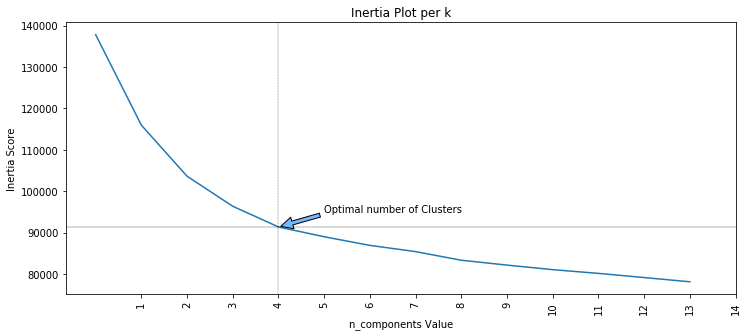

In [120]:
# Re - Running Kmeans on "new" data
X_train = new_raw_data[new_features].values
# Running K means with multible Ks
no_of_clusters = range(1,15) #[2,3,4,5,6,7,8,9]
inertia = []
for k in no_of_clusters:
    kmeans = KMeans(n_clusters=k, random_state=2)
    kmeans = kmeans.fit(X_train)
    u = kmeans.inertia_
    inertia.append(u)
    print("The innertia for :", k, "Clusters is:", u)
    
# Creating the scree plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(12, 5))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')

plt.axhline(91370, color="k", linestyle="-", linewidth=.30)
plt.axvline(4,color="k", linestyle="--", linewidth=.30)

plt.annotate('Optimal number of Clusters', xy=(4, 91370), 
             xytext=(5, 95000),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))

plt.xticks(range(1, 15))
plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

.The inertia(wcss) improved vs the initial run before PCA and Vs the PCA run precisely 5 Clusters is: 101925.20 before PCA, then
5 Clusters is: 93698.19 and now 5 Clusters is: 91370.38.

Explained variance ratio (first two components): [0.192739 0.096016]


<Figure size 720x360 with 0 Axes>

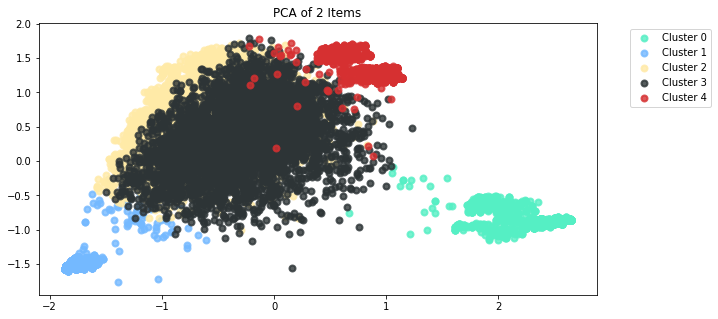

In [122]:
# Running K means on 5 clusters
#instantiate the Kmeans 
kmeans = KMeans(n_clusters=5, init="k-means++", max_iter=300, random_state=88, n_init=10)
#We fit kmeans with the data
kmeans = kmeans.fit(X_train)
#predictions
predictions = kmeans.predict(X_train)

# Running PCA to Visualize the data
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
X = X_train
y_num = predictions
target_names = ["Cluster 0","Cluster 1","Cluster 2", "Cluster 3","Cluster 4"]
pca = PCA(n_components=2, random_state = 88)
X_r = pca.fit(X).transform(X)

# Percentage of variance explained for each components
print('Explained variance ratio (first two components): %s' % str(pca.explained_variance_ratio_))

# Plotting the data
plt.figure()
plt.figure(figsize=(10,5))
colors = ['#55efc4', '#74b9ff', '#ffeaa7', '#2d3436', '#d63031']
lw = 2
for color, i, target_name in zip(colors, [0, 1, 2, 3, 4], target_names):
    plt.scatter(X_r[y_num == i, 0], X_r[y_num == i, 1], color=color, alpha=.8, lw=lw,label=target_name)
    
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)   
plt.title('PCA of 2 Items')
plt.show()

.Now The first two components explain about 19.27% + 9.60% = 29% of the variance in our data set.

**WE RUN THE PCA ON NEW GROUPED DATA SET TO SEARCH THE OPTIMAL NUMBERS OF COMPONENTS**

Total Variance in our dataset is:  9.321122476164975
The 95% variance we want to have is:  8.855066352356726

Variance explain with 30 n_compononets:  8.171778869524074
Variance explain with 35 n_compononets:  8.555750537962897
Variance explain with 36 n_compononets:  8.62087057999474
Variance explain with 38 n_compononets:  8.746073124912504
Variance explain with 40 n_compononets:  8.860931848521192
Variance explain with 41 n_compononets:  8.91190642785989
Variance explain with 50 n_compononets:  9.266005061514615


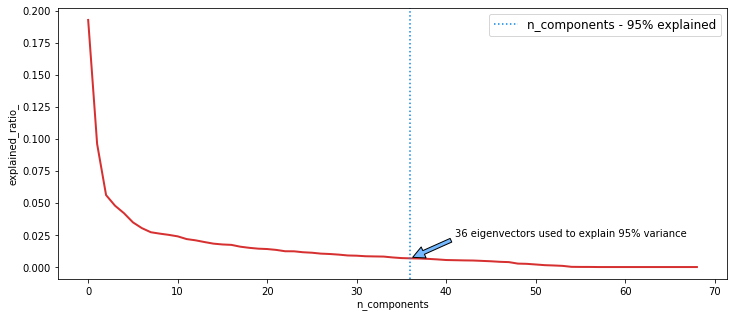

In [127]:
#We will implement Dimensionality reduction and then run Kmeans
#We define the components to reduce (X.shape[1])= 61 columns
n_components = X.shape[1]
# Running PCA with all components
pca = PCA(n_components=n_components, random_state = 88)
X_r = pca.fit(X).transform(X)

# Calculating the 95% Variance
total_variance = sum(pca.explained_variance_)
print("Total Variance in our dataset is: ", total_variance)
var_95 = total_variance * 0.95
print("The 95% variance we want to have is: ", var_95)
print("")

# Creating a df with the components and explained variance
a = zip(range(0,n_components), pca.explained_variance_)
a = pd.DataFrame(a, columns=["PCA Comp", "Explained Variance"])

# Trying to hit 95%
print("Variance explain with 30 n_compononets: ", sum(a["Explained Variance"][0:30]))
print("Variance explain with 35 n_compononets: ", sum(a["Explained Variance"][0:35]))
print("Variance explain with 36 n_compononets: ", sum(a["Explained Variance"][0:36]))
print("Variance explain with 38 n_compononets: ", sum(a["Explained Variance"][0:38]))
print("Variance explain with 40 n_compononets: ", sum(a["Explained Variance"][0:40]))
print("Variance explain with 41 n_compononets: ", sum(a["Explained Variance"][0:41]))
print("Variance explain with 50 n_compononets: ", sum(a["Explained Variance"][0:50]))

# Plotting the Data
plt.figure(1, figsize=(12, 5))
plt.plot(pca.explained_variance_ratio_, linewidth=2, c="#d63031")
plt.xlabel('n_components')
plt.ylabel('explained_ratio_')

# Plotting line with 95% e.v.
plt.axvline(36,linestyle=':', label='n_components - 95% explained', c ="#0984e3")
plt.legend(prop=dict(size=12))

# adding arrow
plt.annotate('36 eigenvectors used to explain 95% variance', 
             xy=(36, pca.explained_variance_ratio_[36]), 
             xytext=(41, pca.explained_variance_ratio_[10]),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))
plt.show()

.With n=36 components, we attain 95% variance of our data. It means that 95% of the variance of our data are expalined by 36 components. 36 is the optimal number of components.

**WE RUN THE PCA WITH THE OPTIMAL NUMBERS OF COMPONENTS**

The inertia for : 1 Clusters is: 127430.04027230438
The inertia for : 2 Clusters is: 105589.74209031761
The inertia for : 3 Clusters is: 93262.92537697149
The inertia for : 4 Clusters is: 86043.03272798128
The inertia for : 5 Clusters is: 81065.25782300138
The inertia for : 6 Clusters is: 78716.79214531163
The inertia for : 7 Clusters is: 76829.5828261461
The inertia for : 8 Clusters is: 74853.15196787234
The inertia for : 9 Clusters is: 73667.4660336218
The inertia for : 10 Clusters is: 71965.10095685117
The inertia for : 11 Clusters is: 70767.30012911698
The inertia for : 12 Clusters is: 69952.61222813647
The inertia for : 13 Clusters is: 68832.71552802241
The inertia for : 14 Clusters is: 68124.89040901065


Text(0.5, 1.0, 'Inertia Plot per k')

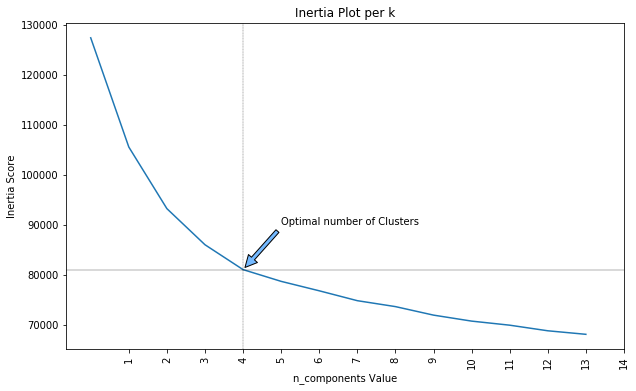

In [129]:
# Running PCA again with the optimal number of components
pca = PCA(n_components=36, random_state = 88)
X_r = pca.fit(X).transform(X)
#we create an empty list to store empty inertia
inertia = []
#running Kmeans
for k in no_of_clusters:
    kmeans = KMeans(n_clusters=k, init="k-means++", max_iter=300, random_state=88, n_init=10)
    kmeans = kmeans.fit(X_r)
    u = kmeans.inertia_
    inertia.append(u)
    print("The inertia for :", k, "Clusters is:", u)
# Creating the screen plot for Intertia - elbow method
fig, (ax1) = plt.subplots(1, figsize=(10, 6))
xx = np.arange(len(no_of_clusters))
ax1.plot(xx, inertia)
ax1.set_xticks(xx)
ax1.set_xticklabels(no_of_clusters, rotation='vertical')

plt.axhline(81065, color="k", linestyle="-", linewidth=.30)
plt.axvline(4,color="k", linestyle="--", linewidth=.30)

plt.annotate('Optimal number of Clusters', xy=(4, 81065), 
             xytext=(5, 90000),
            arrowprops=dict(facecolor='#74b9ff', shrink=0.05))

plt.xticks(range(1, 15))

plt.xlabel('n_components Value')
plt.ylabel('Inertia Score')
plt.title("Inertia Plot per k")

.The Inertia change between 5 to 6 clusters is less stipper than the change between 4 to 5. It implies that 5 is the optimal number of clusters. By reducing the dimensionality of our data from 43 to 36 components, we improve the inertia score from 91370 to 81065.  

# 5. WE RUN THE MODEL WITH THE OPTIMAL PC  AND NUMBER OF CLUSTERS

In [130]:
%%time
# Running PCA with 36 PC
pca = PCA(n_components=36, random_state = 88)
X_r = pca.fit(X).transform(X)

# Running Kmeans with 5 Ks
kmeans = KMeans(n_clusters=5, init="k-means++", max_iter=300, random_state=88, n_init=10)
kmeans = kmeans.fit(X_r)

clusters = kmeans.labels_

# Attach the clusters back to our initial Dataset that has all the data
raw_data['Clusters'] = clusters

# Creating a cluster Category
raw_data['Clusters_Category'] = 'No Data'
raw_data['Clusters_Category'].loc[raw_data['Clusters'] == 0] = 'Cluster 1'
raw_data['Clusters_Category'].loc[raw_data['Clusters'] == 1] = 'Cluster 2'
raw_data['Clusters_Category'].loc[raw_data['Clusters'] == 2] = 'Cluster 3'
raw_data['Clusters_Category'].loc[raw_data['Clusters'] == 3] = 'Cluster 4'
raw_data['Clusters_Category'].loc[raw_data['Clusters'] == 4] = 'Cluster 5'

Wall time: 2.79 s


In [192]:
%%time
# Running PCA with 36 PC
pca = PCA(n_components=36, random_state = 88)
X_r = pca.fit(X).transform(X)

# Running Kmeans with 5 Ks
kmeans = KMeans(n_clusters=5, init="k-means++", max_iter=300, random_state=88, n_init=10)
kmeans = kmeans.fit(X_r)

clusters = kmeans.labels_

# Attach the clusters back to our initial Dataset that has all the data
raw_data_temp['Clusters'] = clusters

# Creating a cluster Category
raw_data_temp['Clusters_Category'] = 'No Data'
raw_data_temp['Clusters_Category'].loc[raw_data_temp['Clusters'] == 0] = 'Cluster 1'
raw_data_temp['Clusters_Category'].loc[raw_data_temp['Clusters'] == 1] = 'Cluster 2'
raw_data_temp['Clusters_Category'].loc[raw_data_temp['Clusters'] == 2] = 'Cluster 3'
raw_data_temp['Clusters_Category'].loc[raw_data_temp['Clusters'] == 3] = 'Cluster 4'
raw_data_temp['Clusters_Category'].loc[raw_data_temp['Clusters'] == 4] = 'Cluster 5'

Wall time: 2.7 s


In [131]:
raw_data.head(5)

,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money,Clusters,Clusters_Category
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree,1,Cluster 2
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree,4,Cluster 5
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I don't spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree,4,Cluster 5
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree,2,Cluster 3
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree,0,Cluster 1


In [132]:
#SQL_Query['do_you_enjoy_adrenaline_rush_activities'].unique()
raw_data.columns

Index(['CUSTOMER', 'Age', 'Gender', 'Postcode', 'District', 'Constituency',
       'latitude', 'longitude', 'Current_Status', 'Total_Household_Income',
       'How_often_you_attend_Entertaining_events_in_a_year', 'Social_Media',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event',
       'Do_you_enjoy_adrenaline_rush_activities',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you',
       'What_is_your_favourite_attraction_from_below',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us',
       'Would_you_recommend_our_events_to_other_people',
       'Did_you_find_our_events_value_for_money', 'Clusters',
       'Clusters_Category'],
      dtype='object')

In [141]:
raw_data_temp.columns

Index(['CUSTOMER', 'Age', 'Gender', 'Postcode', 'District', 'Constituency',
       'latitude', 'longitude', 'Current_Status', 'Total_Household_Income',
       'How_often_you_attend_Entertaining_events_in_a_year', 'Social_Media',
       'How_many_hours_are_you_willing_to_travel_to_attend_an_event',
       'Do_you_enjoy_adrenaline_rush_activities',
       'Are_food_areas_coffee_areas_bars_toilets_important_to_you',
       'What_is_your_favourite_attraction_from_below',
       'Were_you_satisfied_with_the_last_event_you_attended_with_us',
       'Would_you_recommend_our_events_to_other_people',
       'Did_you_find_our_events_value_for_money', 'Event_Lat', 'Event_Lon',
       'DistanceFromEvent'],
      dtype='object')

In [193]:
# Creating an order for Household Income

raw_data_temp['Household_Income_Order'] = 0
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == 'Less than 20,000'] = 1
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '20,000 to 34,999'] = 2
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '35,000 to 49,999'] = 3
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '50,000 to 74,999'] = 4
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '75,000 to 99,999'] = 5
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '100,000 to 149,999'] = 6
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '150,000 to 199,999'] = 7
raw_data_temp['Household_Income_Order'].loc[raw_data_temp['Total_Household_Income'] == '200,000 or more'] = 8

# Replacing apostrophe from columns names
raw_data_temp['Social_Media'] = raw_data_temp['Social_Media'].str.replace("'","")

# Creating an order for Social Media Time Spend
raw_data_temp['Social_Media_Time_Spend_Order'] = 0
raw_data_temp['Social_Media_Time_Spend_Order'].loc[raw_data_temp['Social_Media'] == 'I dont spend any time at all'] = 1
raw_data_temp['Social_Media_Time_Spend_Order'].loc[raw_data_temp['Social_Media'] == 'Up to 1 hour'] = 2
raw_data_temp['Social_Media_Time_Spend_Order'].loc[raw_data_temp['Social_Media'] == 'Up to 2 hours'] = 3
raw_data_temp['Social_Media_Time_Spend_Order'].loc[raw_data_temp['Social_Media'] == 'Half a day'] = 4
raw_data_temp['Social_Media_Time_Spend_Order'].loc[raw_data_temp['Social_Media'] == 'More than half a day'] = 5

# Creating an order for food_areas_coffee_areas_bars_toilets that have Entirely Agree, etc..
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'] = 0
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Entirely agree'] = 1
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Mostly agree'] = 2
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Somewhat agree'] = 3
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Neither agree nor disagree'] = 4
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Somewhat disagree'] = 5
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Mostly disagree'] = 6
raw_data_temp['food_areas_coffee_areas_bars_toilets Agree Order'].loc[raw_data_temp['Are_food_areas_coffee_areas_bars_toilets_important_to_you'] == 'Entirely disagree'] = 7

# Creating an order for do_you_enjoy_adrenaline_rush_activities
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'] = 0
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Entirely agree'] = 1
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Mostly agree'] = 2
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Somewhat agree'] = 3
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Neither agree nor disagree'] = 4
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Somewhat disagree'] = 5
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Mostly disagree'] = 6
raw_data_temp['Enjoy_adrenaline_rush_activities Agree Order'].loc[raw_data_temp['Do_you_enjoy_adrenaline_rush_activities'] == 'Entirely disagree'] = 7

# Creating an order for were_you_satisfied_with_the_last_event_you_attended_with_us
raw_data_temp['Satisfied_Agree_Order'] = 0
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Entirely agree'] = 1
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Mostly agree'] = 2
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Somewhat agree'] = 3
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Neither agree nor disagree'] = 4
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Somewhat disagree'] = 5
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Mostly disagree'] = 6
raw_data_temp['Satisfied_Agree_Order'].loc[raw_data_temp['Were_you_satisfied_with_the_last_event_you_attended_with_us'] == 'Entirely disagree'] = 7

# Creating an order for did_you_find_our_events_value_for_money
raw_data_temp['Value_for_money Agree_Order'] = 0
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Entirely agree'] = 1
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Mostly agree'] = 2
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Somewhat agree'] = 3
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Neither agree nor disagree'] = 4
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Somewhat disagree'] = 5
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Mostly disagree'] = 6
raw_data_temp['Value_for_money Agree_Order'].loc[raw_data_temp['Did_you_find_our_events_value_for_money'] == 'Entirely disagree'] = 7


# Creating an order for would_you_recommend_our_events_to_other_people
raw_data_temp['Recommend_Order'] = 0
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Very Likely'] = 1
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Mostly Likely'] = 2
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Somewhat Likely'] = 3
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Neither agree nor disagree'] = 4
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Somewhat Unlikely'] = 5
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Mostly Unlikely'] = 6
raw_data_temp['Recommend_Order'].loc[raw_data_temp['Would_you_recommend_our_events_to_other_people'] == 'Very Unlikely'] = 7

In [194]:
raw_data_temp.head()

,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money,Event_Lat,Event_Lon,DistanceFromEvent,Clusters,Clusters_Category,Household_Income_Order,Social_Media_Time_Spend_Order,food_areas_coffee_areas_bars_toilets Agree Order,Enjoy_adrenaline_rush_activities Agree Order,Satisfied_Agree_Order,Value_for_money Agree_Order,Recommend_Order
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree,51.5073,0.1657,34.342502,2,Cluster 3,4,2,1,7,3,5,5
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree,51.5073,0.1657,41.376761,2,Cluster 3,3,2,1,5,2,7,3
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I dont spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree,51.5073,0.1657,701.484783,2,Cluster 3,5,1,3,5,2,7,6
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree,51.5073,0.1657,176.943287,3,Cluster 4,3,4,4,1,3,5,3
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree,51.5073,0.1657,17.216110,0,Cluster 1,6,2,4,6,1,1,7


# 6.EXPORTING THE DATA BACK TO A NEW SQL TABLE

In [135]:
from sqlalchemy import create_engine
import urllib
#To open a connextion with sql server
connStr = urllib.parse.quote_plus('DRIVER={SQL Server Native Client 11.0};\
                            SERVER=DESKTOP-JDQLDT1\MSSQLSERVER01;\
                            DATABASE=Customer_Raw_Data;\
                            Trusted_Connection=yes')


engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(connStr))

raw_data.to_sql('Events_Cluster_Output', schema='dbo', con = engine, if_exists = 'replace')
print("Data Successfully Inserted🚦")

In [198]:
#import data with no missing values
from sqlalchemy import create_engine
import urllib
#To open a connextion with sql server
connStr = urllib.parse.quote_plus('DRIVER={SQL Server Native Client 11.0};\
                            SERVER=DESKTOP-JDQLDT1\MSSQLSERVER01;\
                            DATABASE=Customer_Raw_Data;\
                            Trusted_Connection=yes')


engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(connStr))

raw_data_temp.to_sql('Events_Cluster_Output_2', schema='dbo', con = engine, if_exists = 'replace')
print("Data Successfully Inserted🚦")

Data Successfully Inserted🚦


In [199]:
path = r"D:\DataBases\DataSets\Data360"
# Exporting the data in a CSV
raw_data_temp.to_csv(path + '\Events_Cluster_Output_2.csv', sep='\t', index=False)

In [137]:
raw_data.head()

,CUSTOMER,Age,Gender,Postcode,District,Constituency,latitude,longitude,Current_Status,Total_Household_Income,How_often_you_attend_Entertaining_events_in_a_year,Social_Media,How_many_hours_are_you_willing_to_travel_to_attend_an_event,Do_you_enjoy_adrenaline_rush_activities,Are_food_areas_coffee_areas_bars_toilets_important_to_you,What_is_your_favourite_attraction_from_below,Were_you_satisfied_with_the_last_event_you_attended_with_us,Would_you_recommend_our_events_to_other_people,Did_you_find_our_events_value_for_money,Clusters,Clusters_Category,Household_Income_Order,Social_Media_Time_Spend_Order,food_areas_coffee_areas_bars_toilets Agree Order,Enjoy_adrenaline_rush_activities Agree Order,Satisfied_Agree_Order,Value_for_money Agree_Order,Recommend_Order
0,1,40-49,Female,AL9 7BN,Welwyn Hatfield,Welwyn Hatfield,51.727429,-0.183648,Married with children,"50,000 to 74,999",4 Times a Year,Up to 1 hour,3 hours,Entirely disagree,Entirely agree,Ice Bar,Somewhat agree,Somewhat Unlikely,Somewhat disagree,1,Cluster 2,4,2,1,7,3,5,5
1,2,60-64,Male,AL7 1ZW,Welwyn Hatfield,Welwyn Hatfield,51.804482,-0.195898,Married with children,"35,000 to 49,999",3 Times a Year,Up to 1 hour,5 hours,Somewhat disagree,Entirely agree,Happy Rollercoaster,Mostly agree,Somewhat Likely,Entirely disagree,4,Cluster 5,3,2,1,5,2,7,3
2,3,50-59,Male,AB4 5JX,Aberdeenshire,Banff and Buchan,57.692200,-2.022295,Married with children,"75,000 to 99,999",3 Times a Year,I dont spend any time at all,5 hours,Somewhat disagree,Somewhat agree,Happy Rollercoaster,Mostly agree,Mostly Unlikely,Entirely disagree,4,Cluster 5,5,1,3,5,2,7,6
3,4,50-59,Female,B24 0DL,Birmingham,"Birmingham, Erdington",52.526595,-1.822211,Married without children,"35,000 to 49,999",1 Times a Year,Half a day,1 hour,Entirely agree,Neither agree nor disagree,Crazy rollercoaster ride,Somewhat agree,Somewhat Likely,Somewhat disagree,2,Cluster 3,3,4,4,1,3,5,3
4,5,60-64,Male,E17 5QP,Waltham Forest,Walthamstow,51.593979,-0.040803,Married with children,"100,000 to 149,999",3 Times a Year,Up to 1 hour,6 hours plus,Mostly disagree,Neither agree nor disagree,Kids Playground,Entirely agree,Very Unlikely,Entirely agree,0,Cluster 1,6,2,4,6,1,1,7


In [138]:
#To get the working directory
os. getcwd() 

'C:\\Users\\nherm\\Downloads'